In [1]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import warnings; warnings.filterwarnings('ignore')
import random; random.seed(1)

# Topic Modeling - An Empirical Approach to Theme Detection

[*Folgert Karsdorp*](https://github.com/fbkarsdorp)

In this session we will employ an unsupervised model of text, one which often goes under the name 'Topic Model', to explore and make visible thematic aspects in the K-Pop comments dataset. Topic Models, or more precisely, mixed-membership models, have gained a lot of popularity as a method for identifying and organizing topical and thematic structures in text documents and text corpora (see e.g. Blei et al. 2003,  Griffiths & Steyvers 2004). The goal of this session is to introduce the very basics of Topic Models, and, subsequently, to show how Python can be employed to apply Topic Models to the K-Pop dataset. Ignoring any mathematical details, this introduction will primarily focus on the implementation and execution of Topic Models in Python, allowing us to concentrate on the interpretation, evaluation and visualization of the results.

This session is structured as follows. We will first give a brief introduction into the general concepts underlying Topic Modeling. In the subsequent sections, we will work our way through (i) the necessary steps to implement a Topic Model in Python and apply it to the K-Pop dataset, and (ii) the means of evaluating and visualizing the results.

## Topic Modeling

Consider the following five mini-documents:

1. I have tests that I should be studying for but nope, BTS is more important.
2. I really love all these BTS it looks really fun. Makes me want to be a K-Pop idol.
3. Lisa is the cutiest I love her so much 😍😍😍😍😍
4. The camera absolutely loves Lisa.
5. I'm like super late because I never really watch BTS of music videos so how come they fast forward Lisa's rap?

Topic Modeling is essentially a technique to automatically discover 'topics' in these documents (i.e. without utilizing any knowledge except their words). For instance, a Topic Model might discover that documents 1 and 2 are about BTS and K-Pop (Topic 1), whereas documents 3 and 4 are about Lisa from the group Blackpink and how lovable she is (Topic 2). Document 5, then, appears to be a mixture of these two topics. Note that topics are represented as distributions over a vocabulary. For example, Topic 1 could be represented as '50% BTS, 30% K-Pop, 10% videos ...', and Topic 2 as '47% Lisa, 35% love, 4% 😍, ...'. There are various methods to perform Topic Modeling. In what follows, we will discuss and employ the well-known technique 'Latent Dirichlet Allocation' or LDA for short.

Latent Dirichlet Allocation is a so-called *generative model*, which specifies a procedure with which documents are written. LDA has the following naive assumption about how to write a text:

1. Choose the number of words $N$ in your document;
2. Choose a topic mixture $\theta$ for your document (e.g., 60% about Topic 1 and 40% about Topic 2);
3. While the number of generated words is smaller than N, generate a word $w_i$ by:
    1. choosing a topic according to the chosen topic mixture $\theta$;
    2. choosing a word according the topic's distribution over the vocabulary.

According to this procedure, we might write (or generate) a text as follows:

1. We choose our document to be 4 words long;
2. 25% of the document will be about Topic 1 and 75% about Topic 2;
3. By choosing words from Topic 1 and Topic 2, we generate four words: Lisa (T2), love (T2), videos (T1), 😍 (T2).

If it wasn't already, it should be clear by now that LDA has a completely unrealistic view on how documents are created. For example, it completely ignores all syntax and basically treats documents as bags of words. Yet, LDA's generative writing assumption is an explicit and powerful one, which, once reversed, enables us -- at least to a certain extent -- to *infer* topic mixtures and their associated words.

A well-known inference technique is the **collapsed Gibbs sampler** (as discussed in, e.g., Griffiths & Steyvers 2004). Leaving any technicalities aside and glossing over many details, this technique works as follows. Given a collection of documents, we aim to estimate their topic mixtures and the words associated with each topic. First we need to hypothesize how many topics $K$ are in the collection. Subsequently we go over all words in each individual document and randomly(!) assign it to one of the $K$ topics. Note that this random assignment of words to topics already provides us with a topic mixtures and topic-word distribution, though, needless to say, their quality leaves much to be desired. The remaining steps of the procedure aim to improve this initial assignment by iterating over the documents, and for each word $w_i$ in a particular document $d_i$ we compute (i) the proportion with which it occurs with each of the $K$ topics (i.e. $p(w_i | t_i)$, and (ii) the proportion of words in a document assigned to each of the $K$ topics (i.e. $p(t_i | d_i)$). Subsequently, we choose a new topic for $w_i$ with probability $p(w_i | t_i) * p(t_i | d_i)$. By repeating this procedure for a large number of trials, the assignments will slowly improve, thus reflecting a better topic mixture of the documents.

In the remainder of this tutorial, we will apply Topic Modeling to the K-pop dataset. Before that we first need to discuss some essential data preprocessing steps for data representation. This will be the topic of the next section.

## Data Preprocessing

As stated above, Topic Models operate on the word level and ignore the linear ordering of words in documents. As such, all we need to know is how often each word in the collection occurs in each document. An efficient data representation capturing this information is the so-called **bag-of-words model**, in which documents are represented as histograms over the vocabulary (i.e. we list for each word type in the collection how often it occurs in a particular document). A collection of bag-of-words is called a vector-space model. The Machine Learning library scikit-learn provides efficient procedures to construct this representation on the basis of raw text files. In the following code block, we first construct a list containing the paths to all text files in the corpus. For reasons that will be clear in a moment, we subsequently shuffle this list randomly.

In [2]:
import glob

filepaths = glob.glob('../data/kpop_videos_comments/*/*.txt')
random.shuffle(filepaths)

Scikit-learn's `feature_extraction.text` module provides a `CountVectorizer` object with which collections of text documents can easily be converted into a vector space model. In the code block below, we first import the module under the alias `text`. Subsequently, we initialize an instance of `CountVectorizer`. The `CountVectorizer` specifies a wide range of arguments enabling developers to tune the vectorizer to their own needs. Here, we specify the following four arguments. First, we set the input to be a list of filenames, from which the raw contents will be fetched during the vectorization process. Second, the `min_df` argument specifies a the minimum document frequency of terms to be included in the model. All terms that occur in less documents than the value given to `min_df` will be ignored. The third argument specifies a custom regular expression to be used for tokenizing the raw text documents into word tokens. Note that we are only interested in terms with at least three characters. Finally, to remove highly frequent and often less informative words from the model, we specify to ignore all terms present in the English stopword list of Scikit-Learn. After initializing the vectorizer, the method `fit_transform` is called to transform the K-pop comment collection into a document-term matrix, in which rows represent documents and columns the vocabulary of the collection. Individual cells, then, represent the frequency with which particular words occur in specific documents.

In [3]:
import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='filename', min_df=5,
                                  token_pattern=r'\b[A-Za-z]{3,}\b',
                                  stop_words='english')
dtm = vectorizer.fit_transform(filepaths)

As shown by the output of the following code block, the document-term matrix consists of 202 documents (rows), 36,253 word types (columns), and a total of 14,393,178 word tokens:

In [4]:
print(f'Shape of document-term matrix: {dtm.shape}. Number of tokens {dtm.sum()}')

Shape of document-term matrix: (202, 36253). Number of tokens 14393178


Before we move on to the construction of a Topic Model on the basis of this document-term matrix, it would be convenient to first extract the video IDs corresponding to the filenames as well their corresponding K-pop group names:

In [5]:
video_ids = [path.split('/')[-1].replace('.txt', '') for path in filepaths]
group_names = [path.split('/')[-2] for path in filepaths]

## Topic Modeling K-Pop

Having preprocessed and transformed the data collection into a document-term matrix, we move on to the core of this tutorial and construct a Topic Model for the K-pop comments collection. There are a number of high-quality implementations of latent Dirichlet Allocation available in Python, of which [gensim](https://radimrehurek.com/gensim/) by Radim Řehůřek (2010) and Scikit-learn (Pedregosa et al. 2011) are probably the most well-known. In this tutorial we will employ the excellent and intuitive library by Allen Riddell, [`lda`](https://github.com/lda-project/lda), which implements latent Dirichlet allocation (LDA) using collapsed Gibbs sampling. `lda` is fast and is tested on Linux, MacOS, and Windows. It can be installed directly from the notebook by executing the following cell:

In [ ]:
!pip install lda

After installing the package, we import it in the next code block and initialize an instance of `LDA` with 25 topics and 1500 iterations (i.e. passes over the entire collection).

In [7]:
import lda

n_topics = 25
tm = lda.LDA(n_topics=n_topics, n_iter=1500, random_state=1)

Latent Dirichlet Allocation (especially implementations employing the collapsed Gibbs sampler) is a computationally intensive and expensive procedure, which can take a considerable amount of time to train when applied to large text collections. For instance, training a model for the K-pop collection with 1500 iterations and 25 topics takes a little over an hour on a 2015 MacBook Pro. Patient readers are invited to uncomment the following cell and train the model themselves:

In [8]:
# document_topic_distributions = tm.fit_transform(dtm)

For the less patient readers, we have supplied a pre-trained model, which can be loaded by executing the following code block.

In [9]:
# IGNORE THIS CELL WHEN TRAINING THE MODEL YOURSELF!
import numpy as np

tm.components_ = np.load('models/kpop-components-T25.npy')
document_topic_distributions = np.load('models/kpop-dtd-T25.npy')

After training, `tm.components` represents a NumPy array with the topic-word distributions. The topic mixtures per document can be found in `document_topic_distributions` which is also represented as a NumPy array. For exploration purposes, it might be more convenient to convert these two array objects into `DataFrame` objects with explicit row and column names, which is accomplished by executing the following code block.

In [10]:
import pandas as pd

vocab = vectorizer.get_feature_names()
topic_names = [f'Topic {k}' for k in range(1, n_topics + 1)]

topic_word_distributions = pd.DataFrame(
    tm.components_, columns=vocab, index=topic_names)

document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=video_ids)

The index of `document_topic_distributions` refers to the previously compiled list of video IDs. It enables us to conveniently retrieve the topic mixture for a specific document. For example, to list the 10 most likely topics for video `RuntXwPvvaE`, we write:

In [11]:
document_topic_distributions.loc['RuntXwPvvaE'].sort_values(ascending=False).head(10)

Topic 9     0.411601
Topic 20    0.130263
Topic 2     0.101334
Topic 6     0.091489
Topic 4     0.067520
Topic 22    0.047604
Topic 24    0.045788
Topic 8     0.033253
Topic 3     0.031275
Topic 14    0.018772
Name: RuntXwPvvaE, dtype: float64

The DataFrame `topic_word_distributions` has a similar structure, and can be used to retrieve the *n* most likely words in a particular topic. For example, to enumerate the 10 most likely words for Topic 19, we write something like:

In [12]:
topic_word_distributions.loc['Topic 19'].sort_values(ascending=False).head(10)

exo        0.067515
like       0.021686
kai        0.021546
chinese    0.018997
love       0.014939
kris       0.014719
luhan      0.013599
korean     0.012509
version    0.012451
chen       0.011225
Name: Topic 19, dtype: float64

To obtain a better overview of how the different topics are distributed over the K-pop groups, we can compute the mean topic mixtures per group. The following code block employs the efficient `DataFrame.groupby` method to construct a new DataFrame consisting of the mean topic mixture per group:

In [13]:
group_topic_distributions = pd.DataFrame(
    document_topic_distributions.values, index=group_names,
    columns=topic_names).groupby(level=0).mean()
group_topic_distributions

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
blackpink,0.002706,0.031882,0.005176,0.054350,0.000205,0.020246,0.052344,0.086357,0.003353,0.333194,...,0.000808,0.000221,0.043867,0.000251,0.110286,0.003649,0.004051,0.066633,0.086483,0.016798
bts,0.001270,0.131113,0.072429,0.055591,0.001332,0.047998,0.028763,0.058722,0.029394,0.000172,...,0.000181,0.000287,0.019071,0.001744,0.144293,0.000232,0.066232,0.013058,0.120485,0.023581
exo,0.039889,0.027487,0.000566,0.064147,0.032815,0.028269,0.051804,0.077455,0.000674,0.001786,...,0.058731,0.108379,0.048925,0.098735,0.128150,0.079435,0.006819,0.001802,0.106964,0.029674
twice,0.001470,0.023384,0.002011,0.093385,0.001061,0.044231,0.070101,0.086110,0.014791,0.004794,...,0.000659,0.000398,0.030357,0.003387,0.152720,0.005282,0.005195,0.007266,0.077895,0.009029


By visualizing these topic distributions as a bar plot, we obtain a clear overview of which topic feature prominently with each group:

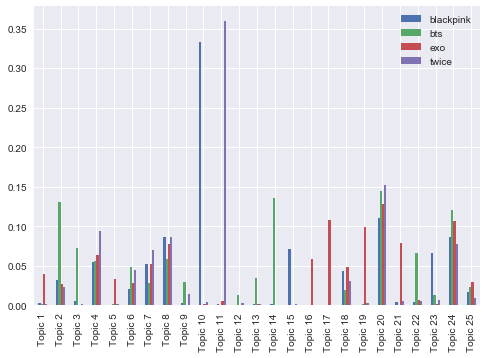

In [14]:
group_topic_distributions.T.plot.bar()

To further explore the topics and topic mixtures inferred by LDA, we will create a more advanced, flexible and detailed visualization using the third-party library [`pyLDAvis`](https://github.com/bmabey/pyLDAvis), which is a Python library for interactive topic model visualization and a port of the fabulous R package by Carson Sievert and Kenny Shirley. The library can be installed from Python Package Index PyPI by executing the following cell:

In [ ]:
!pip install pyLDAvis

`pyLDAvis` is designed to help interpreting topics inferred by a Topic Model by creating an interactive, web-based visualization. Creating this visualization involves two steps. We first 'prepare' the visualization by calling the function `pyLDAvis.prepare`. This function takes the following five arguments: (i) the inferred topic-word distributions, (ii) the inferred document-topic distributions, (iii) the length of each document in the collection, (iv) the vocabulary of the collection, and (v) the frequency of each term in the collection.

In [ ]:
import pyLDAvis

viz_prep = pyLDAvis.prepare(
    topic_word_distributions.values, # (i) see text;
    document_topic_distributions.values, # (ii) see text;
    dtm.sum(axis=1).getA1(), # (iii) compute the total number of tokens in each document;
    vocab, # (iv) see text;
    dtm.sum(axis=0).getA1(), # (v) compute the total frequency of occurrence for each term.
)

In this preparation stage, pyLDAvis will employ a dimension reduction technique (PCA by default) with which the topics and their distances will be plotted in a two-dimensional space. The second step of the visualization is to render the prepared visualization object in the notebook (or save it as an HTML file), which can be accomplished as follows:

In [17]:
pyLDAvis.display(viz_prep)

While pyLDAvis produces a wonderful interactive playground to explore the inferred topics and their relationships in detail, it might sometimes be informative and interesting to gain more insight into which videos are typically associated with a particular topic. By querying the `document_topic_distributions` matrix for a certain topic, we can retrieve the ID of the video in which that topic is most prominent. For example, the following returns the video ID in which Topic 1 features prominently:

In [18]:
document_topic_distributions['Topic 1'].argmax()

'KSH-FVVtTf0'

We could copy the returned video ID and search for the corresponding video on YouTube, but it's much more convenient (and 😎) if we could render the video here in the Jupyter notebook. The following code block implements a small function `best_video_for_topic` which takes the name of a particular topic as argument, and serves the video in which it features most prominently:

In [19]:
from IPython.display import YouTubeVideo

def best_video_for_topic(topic):
    video_id = document_topic_distributions[topic].argmax()
    return YouTubeVideo(video_id)

Let's invoke the function, for instance for Topic 1:

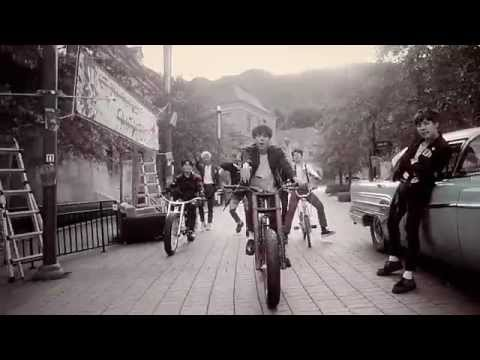

In [20]:
best_video_for_topic('Topic 14')

## Exercises

1. While extremely powerful, Topic Modeling is often considered to be somewhat of a dark  
   magic as it involves numerous parameters that need to be set correctly in order to     
   obtain interesting meaningful results. In this exercise we want you to play around with some of the parameters of the model to obtain more insight in their workings. For example, what happens when the number of topics is increased? And what is the effect of reducing the number of iterations of the Gibbs sampler?
2. After exploring the inferred topics with pyLDAvis, can you come up with a more 
   qualitative analysis of some typical topical differences between the comments about the four K-pop groups?

## References

- Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent Dirichlet
Allocation." *Journal of Machine Learning Research* 3 (2003): 993–1022.
- Griffiths, Thomas L., and Mark Steyvers. "Finding Scientific Topics."
Proceedings of the National Academy of Sciences 101 (2004): 5228–5235.
doi:10.1073/pnas.0307752101.
- Řehůřek, R., and Sojka Petr. "Software Framework for Topic Modelling with Large Corpora." *Proceedings of the LREC 2010 Workshop on New Challenges for NLP Frameworks* (2010): 45-50.
- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.